In [1]:
using StatsBase
using LinearAlgebra
using Statistics

La poblacion de n individuos va a ser un conjunto de {x_i} con xij el j-esimo feature de xi

Despues wik = 1 si el i-esimo individuo esta en el cluster k, 0 sino

La matriz W suma 1 en todas sus filas, pues cada individuo solo pertenece a un cluster

El centroide del k-esimo cluster es c_k y su j-esimo feature es

(suma en i de wik*xij)/ (suma wik) el promedio del j-esimo feature de los individuos en el cluster

Sk(W) = (suma en i de wik * (suma en j de (xij-ckj)^2)) esta es la variacion del k-esimo cluster

S(W) = suma en k de Sk(W) esta es la variacion total de los clusters

Nosotros buscamos minimizar S(W)

#### Representacion:
W lo vamos a representar como un vector de largo n donde cada lugar toma valores {1,...,K}

#### Inicializacion:
Al inicializarlo tenemos que cuidar de no dejar clusters vacios, dado esto, sea p el mayor entero menor a n/K entonces elijo p puntos para ser puesto en cada cluster y luego el resto a cada cluster de forma aleatorio. O sea inicializamos los clusters con la misma cantidad de puntos masomenos

In [2]:
# inicializacion aleatoria de los clusters
# K = cantidad de clusters, n = tamaño de la poblacion
function init_poblation(K,l)
    p = Int(floor(l/K))
    W = zeros(Int64,l)
    for k in 1:K # cada cluster empieza con la misma cantidad minima de individuos
        posiciones_disponibles = [i for i in 1:l if W[i] == 0]
        cluster_k = sample(posiciones_disponibles, p; replace = false)
        for j in cluster_k
            W[j] = k
        end
    end
    for i in 1:l # los individuos que sobran los asigno de forma aleatoria a los clusters
        if W[i] == 0
            W[i] = rand(1:K)
        end
    end
    return W
end

init_poblation (generic function with 1 method)

#### Seleccion:
Luego seleccionamos un individuo de forma proporcional a su fitness value, o sea usamos "fitness_proportionate_selection" o tambien llamada roulette wheel strategy

La funcion de fitness querriamos que sea proporcional a cuanto menor sea S(W), para esto armamos:

g(W) = -S(W) - (f -cσ) con f el valor promedio de -S(W), σ su desviacion estandar y c una constante en [1,3]

Luego F(W) = g(W) si es g(W)>=0

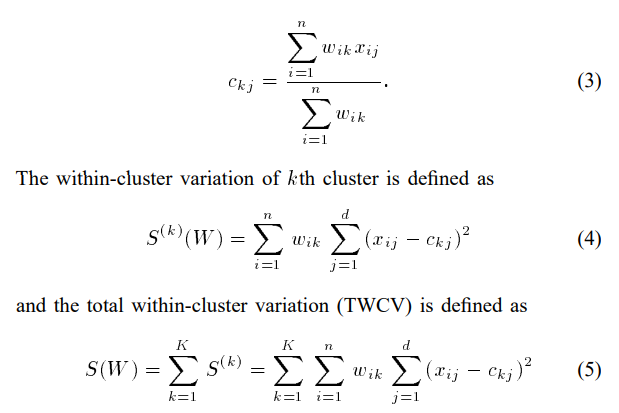

In [3]:
function centroides(data,w,k)
    n = size(data,1) # cantidad de datos
    l = size(data,2) # tamaño de cada dato
    # matriz de k x l donde cada fila tiene el centroide del cluster k
    centroid = zeros(k,l)
    cluster_size = zeros(k)
    for i in 1:n
        j = w[i] # el i-esimo dato pertenece al cluster j
        cluster_size[j] += 1 # agrego un elemento al cluster
        centroid[j, :] += data[i,:] # sumo el dato al centroide
    end
    for h in 1:k
        # promedio por la cantidad de datos en el cluster
        centroid[h,:] *= 1/cluster_size[h]
    end
    return centroid
end

centroides (generic function with 1 method)

In [4]:
function S_k(data, centroids, w, k)
    n = size(data,1) # cantidad de datos 
    res = 0
    for i in 1:n
        if w[i] == k
            res += norm(data[i,:] - centroids[k,:])^2
        end
    end
    return res
end

S_k (generic function with 1 method)

In [5]:
function S(data, centroids, w)
    n = size(data,1) # cantidad de datos 
    res = 0
    for i in 1:n 
        j = w[i]
        res += norm(data[i,:] - centroids[j,:])^2
    end
    return res
end

S (generic function with 1 method)

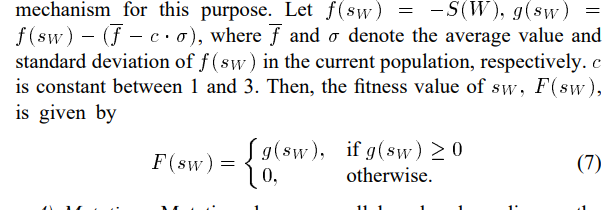

In [6]:
function Fitness(S_pob; c = 2) # le paso las S(w) de cada w en la poblacion,  c cosntante en [1,3]
    prom = -1*mean(S_pob)
    dev = std(S_pob)
    n = length(S_pob)
    res = zeros(n)
    for i in 1:n
        temp = -1*S_pob[i] - (prom - c*dev)
        if temp>0
            res[i] = temp
        end
    end
    return res
end

Fitness (generic function with 1 method)

In [7]:
# necesito seleccionar una cantidad de individuos igual al tamaño de la poblacion
# realizamos fitness_proportionate_selection
function selection(poblation, Fitness_pob)
    l = length(Fitness_pob)
    if Fitness_pob == zeros(l)
        Fitness_pob = ones(l)
    end
    for i in 2:l # convierto f en un vector distribucional
        Fitness_pob[i] += Fitness_pob[i-1]
    end

    # realizamos stochastic_universal_sampling
    value = rand() * Fitness_pob[l]/l
    i = 1
    select_P = [Vector{Int64}() for _ in 1:l]
    for j in 1:l
        while Fitness_pob[i] < value
            i += 1
        end
        select_P[j] = Vector{Int64}(poblation[i])
        value += Fitness_pob[l]/l
    end
    
    return select_P
end

selection (generic function with 1 method)

#### Mutacion:
Va a depender de la distancia del punto al centroide de cada cluster, entonces la proba de que salga el clusters j es p_j:

p_j = (c_m*d_max - d_j)/(suma en i de c_m*d_max - d_i) 

con d_i la distancia del punto al cluster i, d_max el maximo entre estas y c_m una constante usualmente >= 1

Notar que con esto hay clusters que pueden quedar vacios pero eso aumentaria el S(W) por lo que terminarian siendo descartados. Igualmente para evitar esto, solamente cambiaremos un gen si su distancia al centroide es >0

A esta forma de mutar la llamamos DBM1

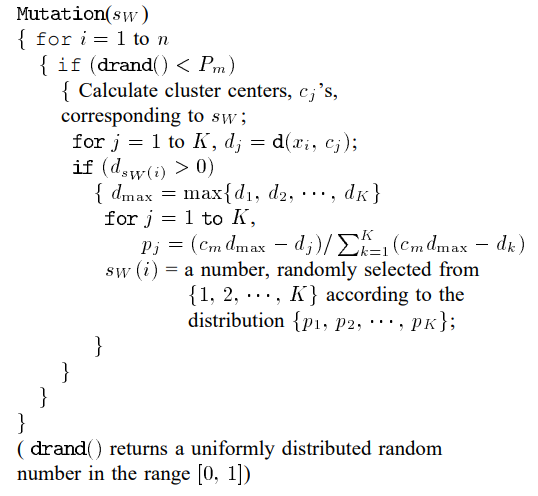

In [8]:
function mutation(data, w, K, p; c_m = 2)
    n = size(data,1)
    for i in 1:n
        if rand() < p
            d = zeros(K)
            # calcular centroides segun w
            centroids = centroides(data,w,K)
            # calculo las distancias a los centroides
            for j in 1:K
                d[j] = norm(data[i,:] - centroids[j,:])^2
            end
            if d[w[i]] > 0
                d_max = maximum(d)
                prob = zeros(K)
                for j in 1:K
                    prob[j] = (c_m*d_max - d[j])
                end
                w[i] = sample(1:K, Weights(prob))
            end
        end
    end
    return w
end

mutation (generic function with 1 method)

#### Operador K-Means:
Consiste en primero calcular los centros de cada cluster, y luego asignar a cada punto al cluster con centroide mas cercano formando W'. 

Esto podria resultar en clusters vacios, por esto creamos clusters unitarios como sea necesario. Lo hacemos sacando un punto del cluster k con mayor Sk(W), en particular el punto mas elejado del centroide. 

Aunque al aplicar KMO y DBM1 consecutivamente no importa como es hecha esta division, la hacemos asi porque se encontro que es mas efectiva y mas barato computacionalmente.

In [9]:
function K_means_operator(data, w, K)
    # realizo una iteracion de K_means
    centroids = centroides(data,w,K)
    n = size(data,1)
    for i in 1:n
        d = zeros(K)
        for j in 1:K
            d[j] = norm(data[i,:] - centroids[j,:])^2
        end
        w[i] = argmin(d)
    end

    clusters_vacios = setdiff(1:K, w)
    S_clusters = zeros(K)

    for vacio in clusters_vacios

        # actualizo los centroides
        centroids = centroides(data,w,K)
        
        # calculo el S_k(w) de cada cluster
        for j in 1:K
            S_clusters[j] = S_k(data, centroids, w, j)
        end

        # agarro el cluster con mayor S_k
        cluster_max = argmax(S_clusters)
        # calculo las distancias de sus puntos al centroide
        centroide_max = centroids[cluster_max,:]

        d_max = [w[i] == cluster_max ? norm(data[i,:] - centroide_max) : 0 for i in 1:n]
        
        indice_lejano = argmax(d_max)

        w[indice_lejano] = vacio
    end
    return w
end

K_means_operator (generic function with 1 method)

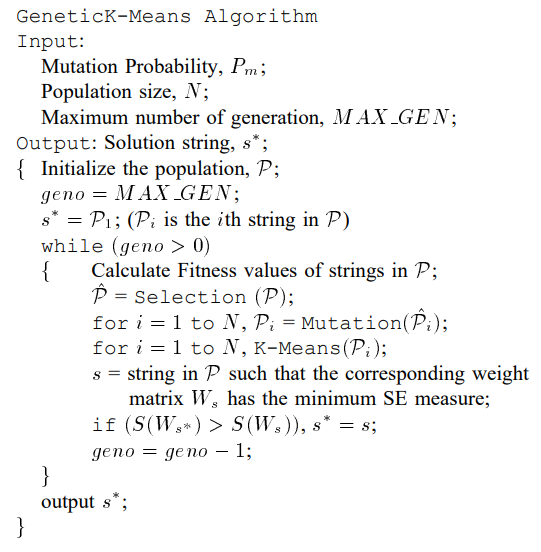

In [10]:
# la data viene en forma matricial tal que data[i,j] es el x_ij descrito arriba
# o sea data[i,j] es el feature j-esimo del i-esimo individuo
# K cantidad de cluster a formar, popsize la cantidad de individuos en cada generacion
# max_gen cantidad de generaciones y p la probabilidad de mutar
function GeneticKMeans(data, K, popsize, max_gen, p)
    # cantidad de genes en cada individuo, o sea cantidad de datos ejemplo
    l = size(data,1)
    poblation = [Vector{Int64}() for _ in 1:popsize]
    # inicializo popsize individuos de forma aleatoria
    for i in 1:popsize
        poblation[i] = init_poblation(K,l)
    end

    best = poblation[1]

    # calculo los valores de fitness para la primera iteracion
    S_pob = zeros(popsize)
    for i in 1:popsize
        centroids = centroides(data,poblation[i],K)
        S_pob[i] = S(data, centroids, poblation[i])
    end
    Fitness_pob = Fitness(S_pob)

    for _ in 1:max_gen
        # selecciono los que dejaran descendencia
        Q = selection(poblation, Fitness_pob)

        # muto los individuos
        for i in 1:popsize
            poblation[i] = mutation(data, Q[i], K, p)
        end

        # realizo K-means
        for i in 1:popsize
            poblation[i] = K_means_operator(data, poblation[i], K)
        end
        
        # calculo el valor de fitness para cada individuo de la poblacion
        for i in 1:popsize
            centroids = centroides(data,poblation[i],K)
            S_pob[i] = S(data, centroids, poblation[i])
        end
        Fitness_pob = Fitness(S_pob)

        # actualizo best
        indice_best = argmax(Fitness_pob)
        best = poblation[indice_best]
    end
    return best
end

GeneticKMeans (generic function with 1 method)